In [1]:
# %%
from pyspark.sql import SparkSession
from pyspark.sql import functions as F


In [2]:
spark = (SparkSession.builder.appName("NBA_Shot_Analysis").getOrCreate())

## Read .csv files

In [3]:
df = spark.read.csv("full shot data.csv", header=True, inferSchema=True).drop("_c0")
players_df = spark.read.csv("NBA shot log 16-17-regular season/Player Regular 16-17 Stats.csv", header=True,
                            inferSchema=True)

## Display schema of DataFrames.

In [4]:
# analyze data
df.printSchema()

root
 |-- self previous shot: string (nullable = true)
 |-- player position: string (nullable = true)
 |-- home game: string (nullable = true)
 |-- location x: double (nullable = true)
 |-- opponent previous shot: string (nullable = true)
 |-- home team: string (nullable = true)
 |-- shot type: string (nullable = true)
 |-- points: integer (nullable = true)
 |-- away team: string (nullable = true)
 |-- location y: double (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- shoot player: string (nullable = true)
 |-- time from last shot: double (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- current shot outcome: string (nullable = true)


In [5]:
players_df.printSchema()

root
 |-- Date/Time of Update: 2017-05-09 4:34:01 PM: string (nullable = true)
 |-- Player ID: integer (nullable = true)
 |-- LastName: string (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- Jersey Num: integer (nullable = true)
 |-- Position: string (nullable = true)
 |-- Height: string (nullable = true)
 |-- Weight: integer (nullable = true)
 |-- Birth Date: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Birth City: string (nullable = true)
 |-- Birth Country: string (nullable = true)
 |-- Rookie: string (nullable = true)
 |-- Team ID: integer (nullable = true)
 |-- Team Abbr: string (nullable = true)
 |-- Team City: string (nullable = true)
 |-- Team Name: string (nullable = true)
 |-- GamesPlayed: integer (nullable = true)
 |-- Fg2PtAtt: integer (nullable = true)
 |-- Fg2PtMade: integer (nullable = true)
 |-- Fg3PtAtt: integer (nullable = true)
 |-- Fg3PtMade: integer (nullable = true)
 |-- FtAtt: integer (nullable = true)
 |-- FtMade: integer (nu

In [6]:
df.show()

+------------------+---------------+---------+----------+----------------------+---------+--------------------+------+---------+----------+-------------------+----------+----------------+-------------------+-------+--------------------+
|self previous shot|player position|home game|location x|opponent previous shot|home team|           shot type|points|away team|location y|               time|      date|    shoot player|time from last shot|quarter|current shot outcome|
+------------------+---------------+---------+----------+----------------------+---------+--------------------+------+---------+----------+-------------------+----------+----------------+-------------------+-------+--------------------+
|              NULL|             SF|      Yes|      97.0|                SCORED|      ATL|    Pullup Jump Shot|     2|      WAS|     405.0|2024-05-12 01:09:00|2016-10-27|   Kent Bazemore|               NULL|      1|              MISSED|
|            MISSED|              C|      Yes|      

In [7]:
players_df.show()

+------------------------------------------+---------+-------------+---------+----------+--------+------+------+----------+---+-----------------+-------------+------+-------+---------+-------------+-------------+-----------+--------+---------+--------+---------+-----+------+
|Date/Time of Update: 2017-05-09 4:34:01 PM|Player ID|     LastName|FirstName|Jersey Num|Position|Height|Weight|Birth Date|Age|       Birth City|Birth Country|Rookie|Team ID|Team Abbr|    Team City|    Team Name|GamesPlayed|Fg2PtAtt|Fg2PtMade|Fg3PtAtt|Fg3PtMade|FtAtt|FtMade|
+------------------------------------------+---------+-------------+---------+----------+--------+------+------+----------+---+-----------------+-------------+------+-------+---------+-------------+-------------+-----------+--------+---------+--------+---------+-----+------+
|                                      NULL|    10138|      Abrines|     Alex|         8|       F| 6'6""|   190|  8/1/1993| 23|Palma de Mallorca|        Spain|     Y|     9

## Data Cleaning

In [8]:
players_df = players_df.withColumn("Name", F.concat_ws(" ", players_df.FirstName, players_df.LastName))

In [9]:
df = df.drop('date', 'home game', 'home team', 'away team', 'FtMade',
             'self previous shot', 'opponent previous shot')

In [10]:
players_df = players_df.drop("Date/Time of Update: 2017-05-09 4:34:01 PM", "Player ID",
                             "Jersey Num", "Birth Date", "Birth City", "Birth Country",
                             "Team ID", "Team Abbr", "Team City", "Team Name", "FirstName",
                             "LastName", "Position", "FtAtt", "FtMade")

players_df.show()

+------+------+---+------+-----------+--------+---------+--------+---------+--------------------+
|Height|Weight|Age|Rookie|GamesPlayed|Fg2PtAtt|Fg2PtMade|Fg3PtAtt|Fg3PtMade|                Name|
+------+------+---+------+-----------+--------+---------+--------+---------+--------------------+
| 6'6""|   190| 23|     Y|         73|      94|       40|     247|       94|        Alex Abrines|
| 6'7""|   240| 26|     N|         46|      80|       33|      90|       37|          Quincy Acy|
| 7'0""|   255| 23|     N|         81|     652|      374|       2|        0|        Steven Adams|
| 6'5""|   215| 31|     N|         71|     269|      123|     151|       62|       Arron Afflalo|
| 7'2""|   248| 29|     N|         55|     174|       89|       4|        0|       Alexis Ajinca|
|6'11""|   245| 28|     N|         72|      86|       45|       0|        0|        Cole Aldrich|
|6'11""|   240| 31|     N|         81|     993|      477|      56|       23|   LaMarcus Aldridge|
| 6'8""|   245| 21| 

In [11]:
df.describe().show()

+-------+---------------+------------------+--------------------+-------------------+------------------+-------------+-------------------+------------------+--------------------+
|summary|player position|        location x|           shot type|             points|        location y| shoot player|time from last shot|           quarter|current shot outcome|
+-------+---------------+------------------+--------------------+-------------------+------------------+-------------+-------------------+------------------+--------------------+
|  count|         210072|            209675|              210072|             210072|            209675|       210072|             200072|            210072|              210072|
|   mean|           NULL| 468.5245069750805|                NULL|  2.316129707909669|249.44723023727198|         NULL| 33.279489383821826|2.4803829163334474|                NULL|
| stddev|           NULL|345.06365363364574|                NULL|0.46496531572046473|111.02319967898579| 

### Handling Missing Values

In [12]:
df.select([F.sum(F.when(df[col].isNull(), 1).otherwise(0)).alias(col) for col in df.columns]).show()

+---------------+----------+---------+------+----------+----+------------+-------------------+-------+--------------------+
|player position|location x|shot type|points|location y|time|shoot player|time from last shot|quarter|current shot outcome|
+---------------+----------+---------+------+----------+----+------------+-------------------+-------+--------------------+
|              0|       397|        0|     0|       397|   0|           0|              10000|      0|                   0|
+---------------+----------+---------+------+----------+----+------------+-------------------+-------+--------------------+


In [13]:
# knn impuation for time from last shot
from pyspark.ml.feature import Imputer
imputer = Imputer(inputCols=["time from last shot"], outputCols=["time from last shot"])
df = imputer.fit(df).transform(df)

In [14]:
df = df.dropna(subset=['location x', 'location y'])

In [15]:
players_df.describe().show()

+-------+------+------------------+------------------+------+------------------+------------------+------------------+------------------+-----------------+-------------+
|summary|Height|            Weight|               Age|Rookie|       GamesPlayed|          Fg2PtAtt|         Fg2PtMade|          Fg3PtAtt|        Fg3PtMade|         Name|
+-------+------+------------------+------------------+------+------------------+------------------+------------------+------------------+-----------------+-------------+
|  count|   510|               510|               508|   517|               517|               517|               517|               517|              517|          517|
|   mean|  NULL|219.36274509803923|26.828740157480315|  NULL| 56.41586073500967|277.87620889748547|139.86847195357834|128.45261121856868|45.93617021276596|         NULL|
| stddev|  NULL|27.184080779978242|4.4014746483738465|  NULL|26.839228128882763| 276.3181519194374|142.57880356135038|146.35076591552158|55.5304388492

In [16]:
players_df = players_df.filter("Fg2PtAtt != 0 and Fg3PtAtt != 0")

In [17]:
players_df.select(
    [F.sum(F.when(players_df[col].isNull(), 1).otherwise(0)).alias(col) for col in players_df.columns]).show()

+------+------+---+------+-----------+--------+---------+--------+---------+----+
|Height|Weight|Age|Rookie|GamesPlayed|Fg2PtAtt|Fg2PtMade|Fg3PtAtt|Fg3PtMade|Name|
+------+------+---+------+-----------+--------+---------+--------+---------+----+
|     3|     3|  5|     0|          0|       0|        0|       0|        0|   0|
+------+------+---+------+-----------+--------+---------+--------+---------+----+


In [18]:
# convert height to cm
split_col = F.split(players_df['Height'], "'")
split_col2 = F.split(split_col[1], '"')
players_df = players_df.withColumn('Height', split_col[0].cast("int") * 30.48 + split_col2[0].cast("int") * 2.54)

In [19]:
age_mean = players_df.select(F.mean(players_df['Age'])).collect()[0][0]
height_mean = players_df.select(F.mean(players_df['Height'])).collect()[0][0]
weight_mean = players_df.select(F.mean(players_df['Weight'])).collect()[0][0]

players_df = players_df.fillna(age_mean, subset=['Age'])
players_df = players_df.fillna(height_mean, subset=['Height'])
players_df = players_df.fillna(weight_mean, subset=['Weight'])

## Joining DataFrames

In [20]:
df = df.join(players_df, df["shoot player"] == players_df["Name"])

In [21]:
df.show()

+---------------+----------+--------------------+------+----------+-------------------+----------------+-------------------+-------+--------------------+------------------+------+---+------+-----------+--------+---------+--------+---------+----------------+
|player position|location x|           shot type|points|location y|               time|    shoot player|time from last shot|quarter|current shot outcome|            Height|Weight|Age|Rookie|GamesPlayed|Fg2PtAtt|Fg2PtMade|Fg3PtAtt|Fg3PtMade|            Name|
+---------------+----------+--------------------+------+----------+-------------------+----------------+-------------------+-------+--------------------+------------------+------+---+------+-----------+--------+---------+--------+---------+----------------+
|             SF|      97.0|    Pullup Jump Shot|     2|     405.0|2024-05-12 01:09:00|   Kent Bazemore| 33.279489383821826|      1|              MISSED|195.57999999999998|   201| 27|     N|         77|     456|      203|     

In [22]:
df = df.withColumn("2PTsAccuracy", df.Fg2PtMade / df.Fg2PtAtt)
df = df.withColumn("3PTsAccuracy", df.Fg3PtMade / df.Fg3PtAtt)
df = df.drop("Fg2PtMade", "Fg2PtAtt", "Fg3PtMade", "Fg3PtAtt")

In [23]:
df = df.drop("shoot player", "Name")
df.show()

+---------------+----------+--------------------+------+----------+-------------------+-------------------+-------+--------------------+------------------+------+---+------+-----------+-------------------+-------------------+
|player position|location x|           shot type|points|location y|               time|time from last shot|quarter|current shot outcome|            Height|Weight|Age|Rookie|GamesPlayed|       2PTsAccuracy|       3PTsAccuracy|
+---------------+----------+--------------------+------+----------+-------------------+-------------------+-------+--------------------+------------------+------+---+------+-----------+-------------------+-------------------+
|             SF|      97.0|    Pullup Jump Shot|     2|     405.0|2024-05-12 01:09:00| 33.279489383821826|      1|              MISSED|195.57999999999998|   201| 27|     N|         77| 0.4451754385964912| 0.3458646616541353|
|              C|      52.0|       Tip Dunk Shot|     2|     250.0|2024-05-12 01:11:00|         

In [24]:
# check for duplicate rows
print(df.count())
print(df.distinct().count())

df = df.dropDuplicates()

204762
204761


In [25]:
# check for unique values for all columns
for col in df.columns:
    print(col, df.select(col).distinct().count())
    

player position 7
location x 717
shot type 834
points 2
location y 489
time 719
time from last shot 201
quarter 8
current shot outcome 3
Height 21
Weight 86
Age 22
Rookie 2
GamesPlayed 78
2PTsAccuracy 393
3PTsAccuracy 317


## Exploratory Data Analysis

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


<Axes: xlabel='current shot outcome', ylabel='count'>

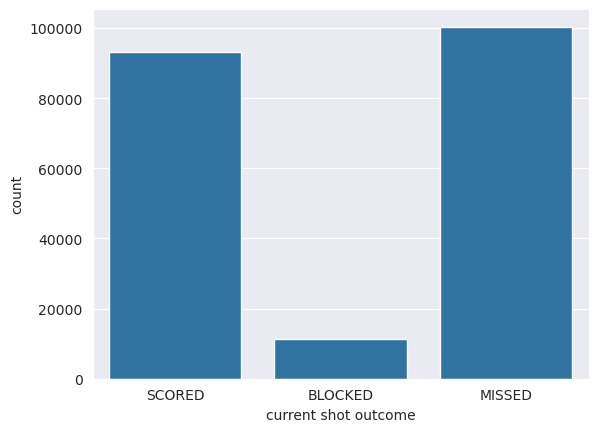

In [27]:
current_shot_outcome = df.groupBy("current shot outcome").count().toPandas()
sns.barplot(x="current shot outcome", y="count", data=current_shot_outcome)

In [28]:
# drop blocked shots
df = df.filter(df["current shot outcome"] != "BLOCKED")

<Axes: xlabel='location x', ylabel='Scored'>

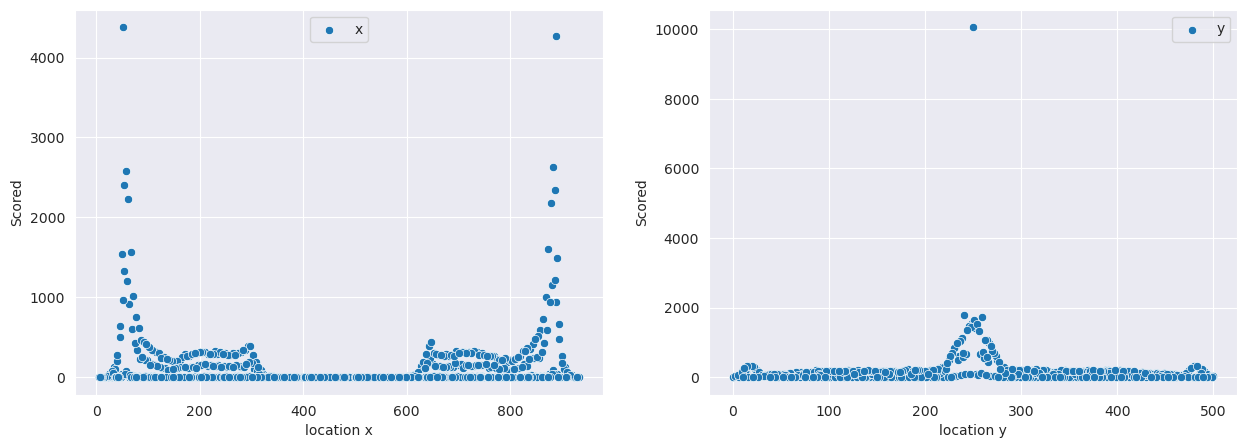

In [29]:
## plot height vs current shot outcome
shotcount_locationx = df.groupBy("location x").agg(
    F.count(F.when(df["current shot outcome"] == "SCORED", 1)).alias("Scored"),
    F.count(F.when(df["current shot outcome"] == "MISSED", 1)).alias("Missed")).toPandas()

shotcount_locationy = df.groupBy("location y").agg(
    F.count(F.when(df["current shot outcome"] == "SCORED", 1)).alias("Scored"),
    F.count(F.when(df["current shot outcome"] == "MISSED", 1)).alias("Missed")).toPandas()

# plot location x and y vs current shot outcome on same plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x="location y", y="Scored", data=shotcount_locationy, label="y", ax=axs[1])
sns.scatterplot(x="location x", y="Scored", data=shotcount_locationx, label="x", ax=axs[0])

<Axes: xlabel='location x', ylabel='Missed'>

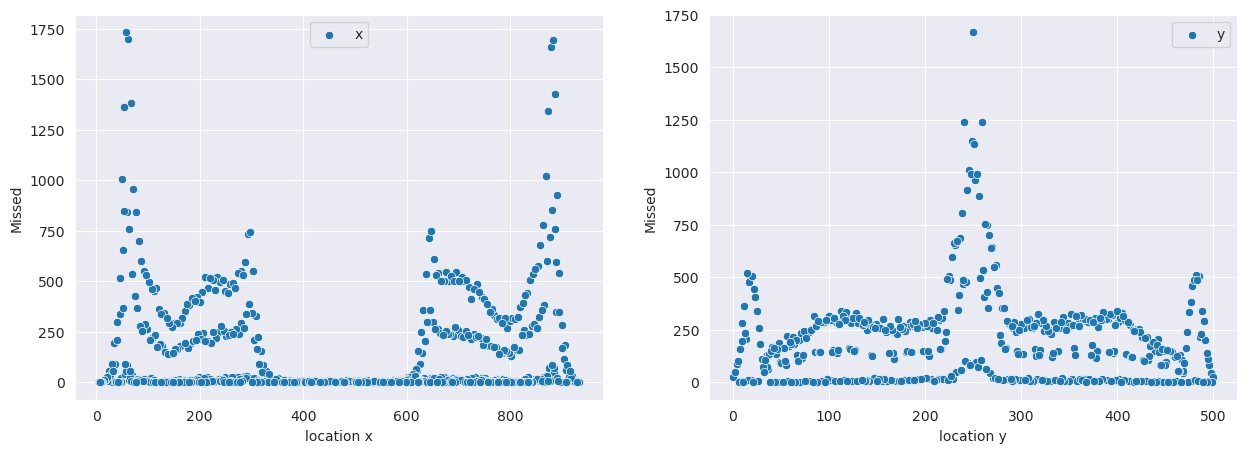

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x="location y", y="Missed", data=shotcount_locationy, label="y", ax=axs[1])
sns.scatterplot(x="location x", y="Missed", data=shotcount_locationx, label="x", ax=axs[0])

In [31]:
# get x to the nearest basket
max_x = df.agg(F.max(df["location x"])).collect()[0][0]
df = df.withColumn("location x",
                   F.when(df["location x"] > max_x / 2, max_x - df["location x"]).otherwise(df["location x"]))

<Axes: xlabel='player position', ylabel='Count'>

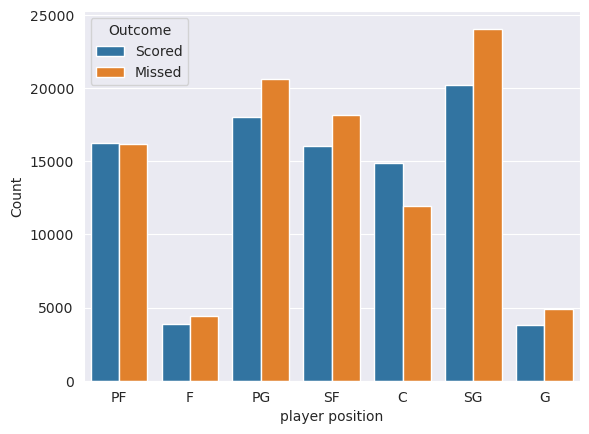

In [32]:
playerposition = df.groupBy("player position").agg(
    F.count(F.when(df["current shot outcome"] == "SCORED", 1)).alias("Scored"),
    F.count(F.when(df["current shot outcome"] == "MISSED", 1)).alias("Missed")).toPandas()

playerposition_melted = playerposition.melt(id_vars=["player position"], value_vars=["Scored", "Missed"],
                                            var_name="Outcome", value_name="Count")

sns.barplot(x="player position", y="Count", hue="Outcome", data=playerposition_melted)


<Axes: xlabel='player position', ylabel='2PTsAccuracy'>

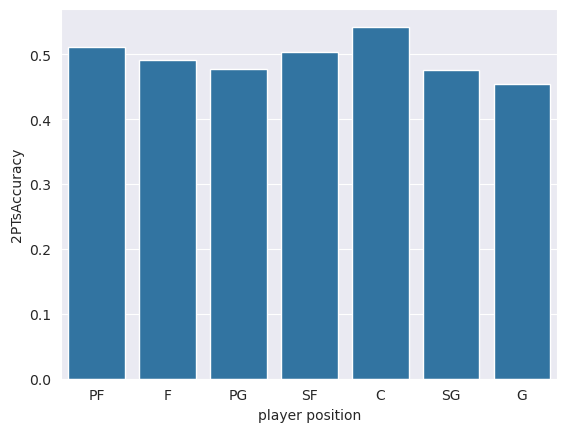

In [33]:
position = df.groupBy("player position").agg(F.mean("2PTsAccuracy").alias("2PTsAccuracy")).toPandas()

sns.barplot(x="player position", y="2PTsAccuracy", data=position)

<Axes: xlabel='player position', ylabel='3PTsAccuracy'>

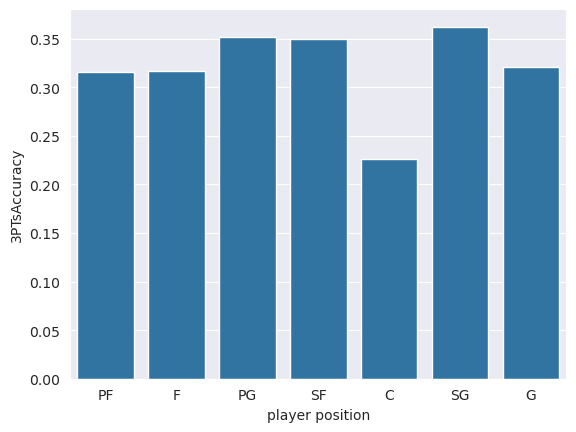

In [34]:
position = df.groupBy("player position").agg(F.mean("3PTsAccuracy").alias("3PTsAccuracy")).toPandas()

sns.barplot(x="player position", y="3PTsAccuracy", data=position)

<Axes: xlabel='HeightGroup', ylabel='Accuracy'>

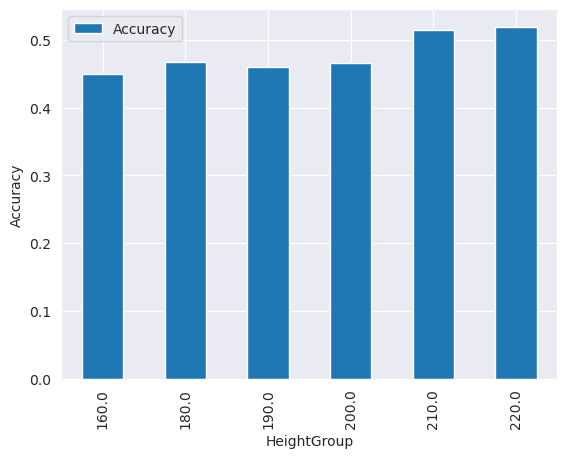

In [35]:
accuracy_df = df.withColumn('HeightGroup', (F.round(df['Height'] / 10) * 10))

# Group by height group and calculate accuracy
accuracy_df = accuracy_df.groupBy('HeightGroup').agg(
    (F.sum(F.when(accuracy_df['current shot outcome'] == 'SCORED', 1)) / F.count(accuracy_df['current shot outcome'])).alias('Accuracy')
)

accuracy_pd = accuracy_df.toPandas()

accuracy_pd = accuracy_pd.sort_values('HeightGroup')

accuracy_pd.plot(x='HeightGroup', ylabel='Accuracy',kind='bar')

<Axes: xlabel='points', ylabel='Count'>

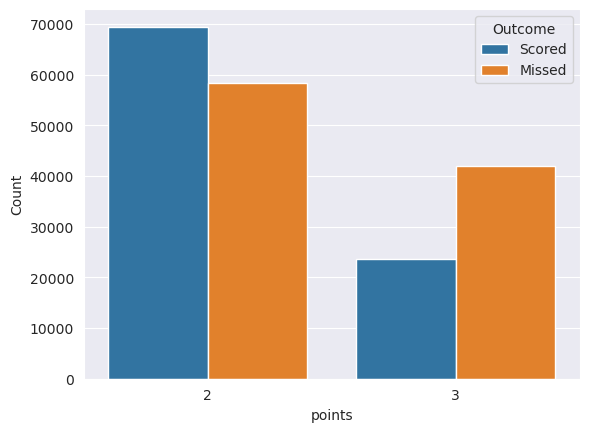

In [36]:
points = df.groupBy("points").agg(F.count(F.when(df["current shot outcome"] == "SCORED", 1)).alias("Scored"),
                                  F.count(F.when(df["current shot outcome"] == "MISSED", 1)).alias("Missed")).toPandas()

points_melted = points.melt(id_vars=["points"], value_vars=["Scored", "Missed"], var_name="Outcome", value_name="Count")

sns.barplot(x="points", y="Count", hue="Outcome", data=points_melted)

<Axes: xlabel='Rookie', ylabel='Count'>

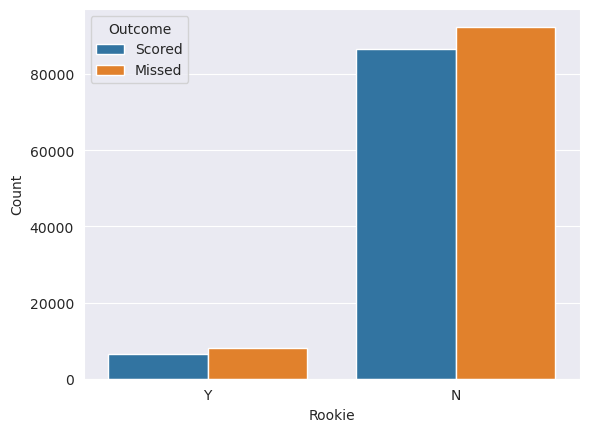

In [37]:
# Rookie = Y and Veteran = N
rookie = df.groupBy("Rookie").agg(F.count(F.when(df["current shot outcome"] == "SCORED", 1)).alias("Scored"),
                                  F.count(F.when(df["current shot outcome"] == "MISSED", 1)).alias("Missed")).toPandas()

rookie_melted = rookie.melt(id_vars=["Rookie"], value_vars=["Scored", "Missed"], var_name="Outcome", value_name="Count")

sns.barplot(x="Rookie", y="Count", hue="Outcome", data=rookie_melted)


In [38]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

numerical_columns = ['time']
category_columns = ["player position", "Rookie", 'quarter', 'shot type']
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in category_columns]

for indexer in indexers:
    df = indexer.fit(df).transform(df)

encoders = OneHotEncoder(inputCol="player position_index", outputCol="player position_encoded")

df = encoders.fit(df).transform(df).drop("player position", "Rookie", "player position_index", 'quarter', 'shot type')

# df.show()

In [39]:
from pyspark.sql.functions import unix_timestamp

# Assuming df is your DataFrame and "timestamp_column" is the column with the timestamp
df = df.withColumn("time", unix_timestamp("time"))

<Axes: >

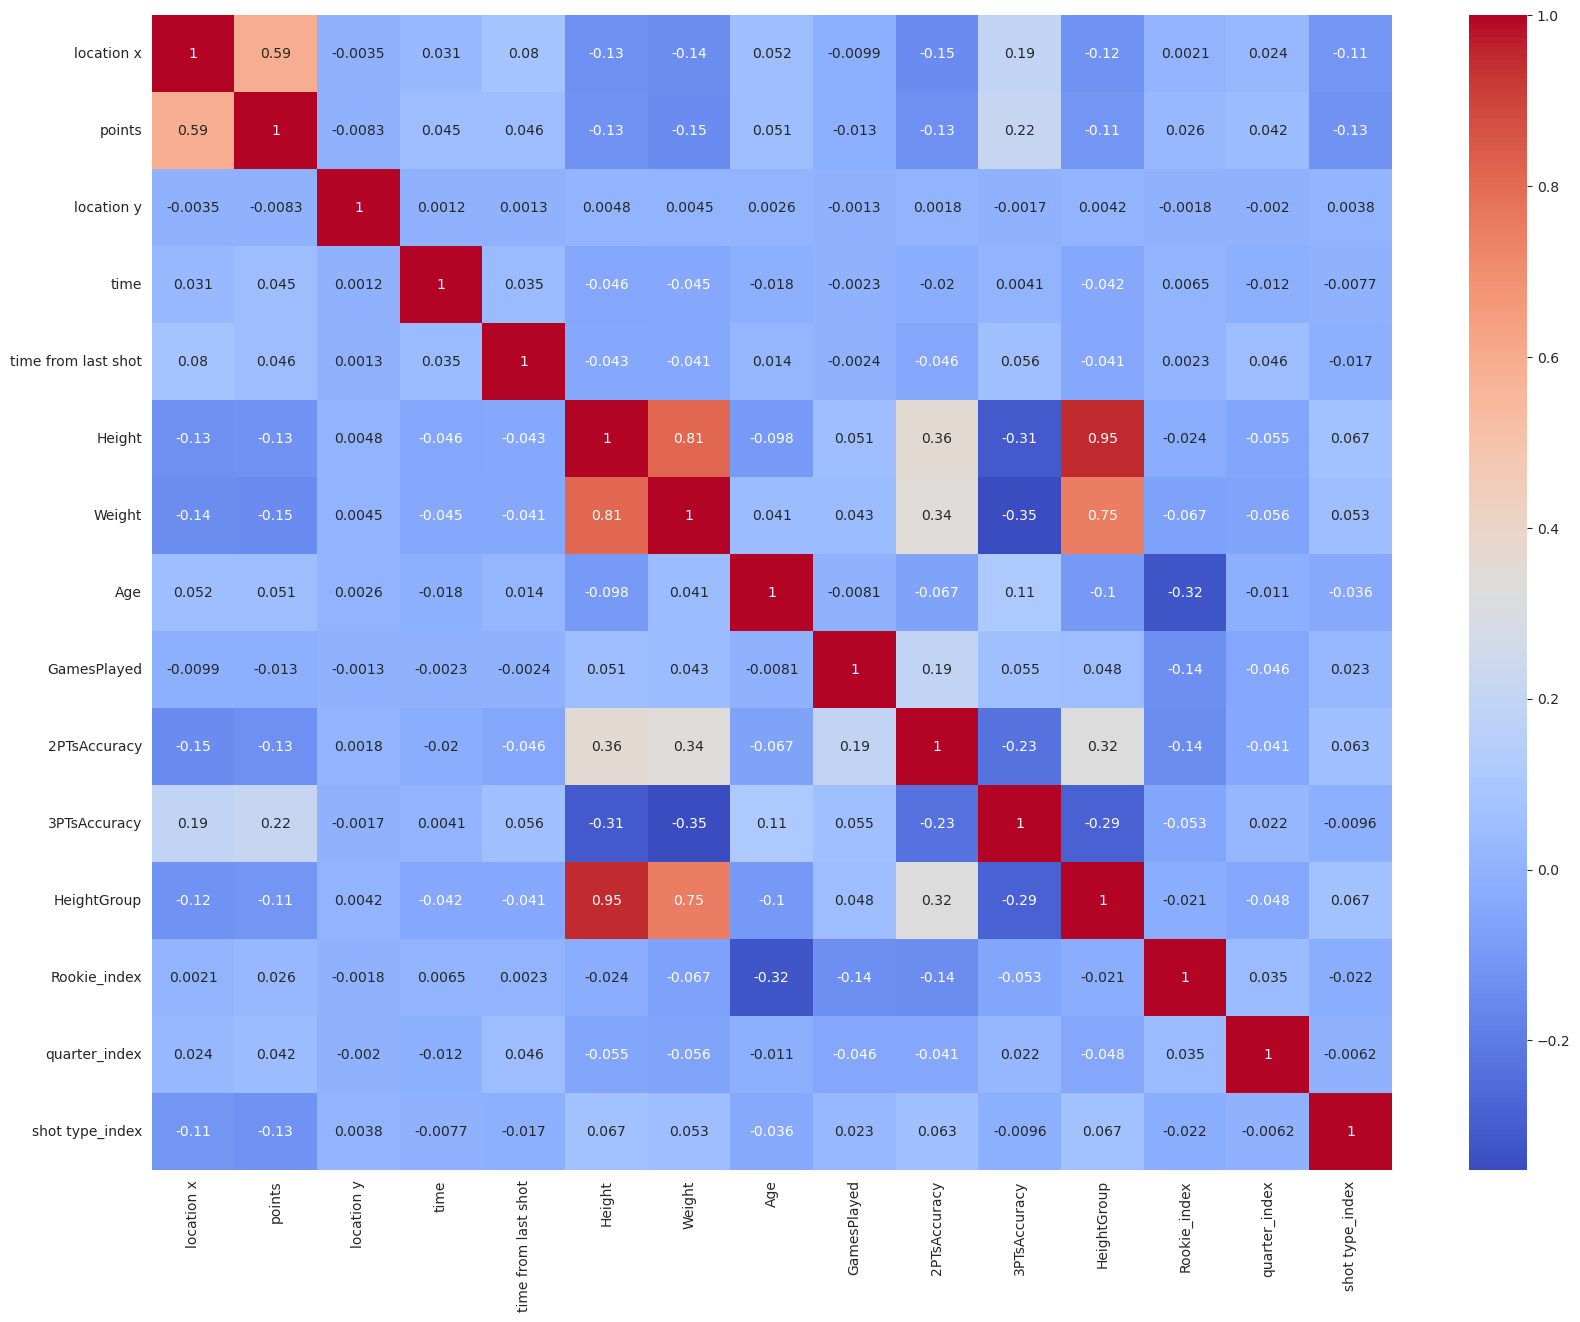

In [40]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

column_names = df.columns
column_names.remove("current shot outcome")
column_names.remove("player position_encoded")

assembler = VectorAssembler(inputCols=column_names, outputCol="features")
matrix = Correlation.corr(assembler.transform(df), "features").head()[0].toArray()

fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(matrix, annot=True, xticklabels=column_names, yticklabels=column_names, ax=ax, cmap="coolwarm")

# split data into training and testing

In [42]:
column_names = [col for col in column_names if
                col not in ["player position_encoded", "Rookie_index", "2PTsAccuracy","3PTsAccuracy", "points"]]
assembler = VectorAssembler(inputCols=column_names, outputCol="feature_noScaling")
df = assembler.transform(df)

train, test = df.randomSplit([0.8, 0.2])

# normalize data

In [43]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="feature_noScaling", outputCol="scaled_features")
scaler_model = scaler.fit(train)
train = scaler_model.transform(train)
test = scaler_model.transform(test)

In [44]:
assembler = VectorAssembler(
    inputCols=["scaled_features", "player position_encoded", "Rookie_index", "2PTsAccuracy","3PTsAccuracy", "points"],
    outputCol="features")
train = assembler.transform(train).select("features", "current shot outcome")
test = assembler.transform(test).select("features", "current shot outcome")

## Model Building

In [45]:
train = train.withColumn("current shot outcome", F.when(df["current shot outcome"] == "SCORED", 1).otherwise(0))
test = test.withColumn("current shot outcome", F.when(df["current shot outcome"] == "SCORED", 1).otherwise(0))

In [46]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="current shot outcome")
lr_model = lr.fit(train)

train_predictions = lr_model.transform(train)
test_predictions = lr_model.transform(test)

<Axes: xlabel='prediction', ylabel='current shot outcome'>

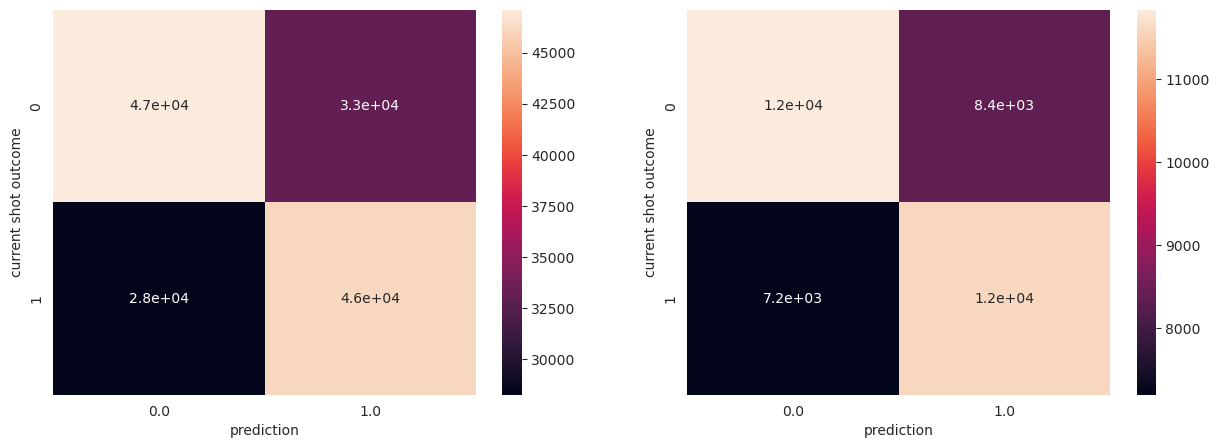

In [47]:
cmtrain = train_predictions.groupBy("current shot outcome", "prediction").count().toPandas()
cmtest = test_predictions.groupBy("current shot outcome", "prediction").count().toPandas()

import pandas as pd
import seaborn as sns
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(pd.pivot_table(cmtrain, values="count", index="current shot outcome", columns="prediction"), annot=True,
            ax=axs[0])
sns.heatmap(pd.pivot_table(cmtest, values="count", index="current shot outcome", columns="prediction"), annot=True,
            ax=axs[1])


In [49]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="current shot outcome", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(train_predictions)
print("train Accuracy: ", accuracy)
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="current shot outcome", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(test_predictions)
print("test Accuracy: ", accuracy)

# Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="current shot outcome", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(train_predictions)
print("train Precision: ", precision)
precision_evaluator = MulticlassClassificationEvaluator(labelCol="current shot outcome", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(test_predictions)
print("test Precision: ", precision)

# Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="current shot outcome", metricName="weightedRecall")
recall = recall_evaluator.evaluate(train_predictions)
print("train Recall: ", recall)
recall_evaluator = MulticlassClassificationEvaluator(labelCol="current shot outcome", metricName="weightedRecall")
recall = recall_evaluator.evaluate(test_predictions)
print("test Recall: ", recall)

# F1 Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="current shot outcome", metricName="f1")
f1 = f1_evaluator.evaluate(train_predictions)
print("train F1 Score: ", f1)
f1_evaluator = MulticlassClassificationEvaluator(labelCol="current shot outcome", metricName="f1")
f1 = f1_evaluator.evaluate(test_predictions)
print("test F1 Score: ", f1)

train Accuracy:  0.6029310902620512
test Accuracy:  0.601139308716738
train Precision:  0.604279615524647
test Precision:  0.6023632846273749
train Recall:  0.602931090262051
test Recall:  0.601139308716738
train F1 Score:  0.6030119104971018
test F1 Score:  0.6012165204125645


In [50]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="current shot outcome", numTrees=30, maxDepth=10)
rf_model = rf.fit(train)

train_predictions = rf_model.transform(train)
test_predictions = rf_model.transform(test)

<Axes: xlabel='prediction', ylabel='current shot outcome'>

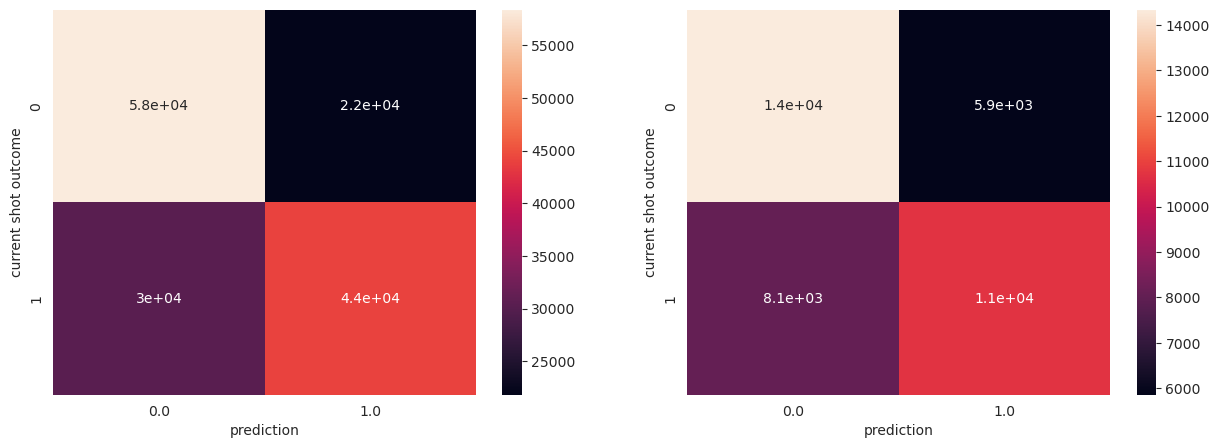

In [51]:
cmtrain = train_predictions.groupBy("current shot outcome", "prediction").count().toPandas()
cmtest = test_predictions.groupBy("current shot outcome", "prediction").count().toPandas()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(pd.pivot_table(cmtrain, values="count", index="current shot outcome", columns="prediction"), annot=True,
            ax=axs[0])
sns.heatmap(pd.pivot_table(cmtest, values="count", index="current shot outcome", columns="prediction"), annot=True,
            ax=axs[1])




In [52]:
# Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="current shot outcome", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(train_predictions)
print("train Accuracy: ", accuracy)
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="current shot outcome", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(test_predictions)
print("test Accuracy: ", accuracy)

# Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="current shot outcome", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(train_predictions)
print("train Precision: ", precision)
precision_evaluator = MulticlassClassificationEvaluator(labelCol="current shot outcome", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(test_predictions)
print("test Precision: ", precision)

# Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="current shot outcome", metricName="weightedRecall")
recall = recall_evaluator.evaluate(train_predictions)
print("train Recall: ", recall)
recall_evaluator = MulticlassClassificationEvaluator(labelCol="current shot outcome", metricName="weightedRecall")
recall = recall_evaluator.evaluate(test_predictions)
print("test Recall: ", recall)

# F1 Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="current shot outcome", metricName="f1")
f1 = f1_evaluator.evaluate(train_predictions)
print("train F1 Score: ", f1)
f1_evaluator = MulticlassClassificationEvaluator(labelCol="current shot outcome", metricName="f1")
f1 = f1_evaluator.evaluate(test_predictions)
print("test F1 Score: ", f1)

train Accuracy:  0.6624393400194112
test Accuracy:  0.6427086808139386
train Precision:  0.6630197685567654
test Precision:  0.6430814227142121
train Recall:  0.6624393400194112
test Recall:  0.6427086808139386
train F1 Score:  0.6606920248201982
test F1 Score:  0.640807542747746


In [53]:
from pyspark.sql.functions import monotonically_increasing_id
train = train.withColumn("row_id", monotonically_increasing_id())
row_index_to_remove = 1  # Index of the row to remove
df_filtered = train.filter(train["row_id"] != row_index_to_remove)

# Drop the row_id column
df_filtered = train.drop("row_id")

<h1>Map reduce</h1>

In [54]:

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import threading
from random import shuffle
from collections import Counter
from threading import Lock
from ast import literal_eval

In [55]:
from sklearn.metrics import accuracy_score, classification_report

class classifier:
    def __init__(self, input_file, output_dir, n_mappers, n_reducers, combiner, preprocess, sub_classifier_config):
        self.input_file = input_file
        self.output_dir = output_dir
        self.n_mappers = n_mappers
        self.n_reducers = n_reducers
        self.combiner = combiner
        self.preprocess = preprocess
        self.config = sub_classifier_config
    
    def preprocess_data(self, df: pd.DataFrame):
        self.labels: list = df["current shot outcome"].unique().tolist() 
        df["current shot outcome"] = df["current shot outcome"].apply(lambda x: self.labels.index(x))
        return df
        
        
    def split_n_shuffle(self, file = None):
        
        if self.input_file:
            try:
                df = pd.read_csv(self.input_file)
            except Exception as e:
                print(e)
                return 
        df = file.toPandas()
        df[self.config["input"]] = df[self.config["input"]].apply(lambda x: x.toArray()).tolist()
        split_size = self.n_mappers
        headers = df.columns
        chunks = np.array_split(df.to_numpy(), split_size)
        shuffle(chunks)
        list_of_df = [pd.DataFrame(data = chunk, columns = headers) for chunk in chunks]
        self.temp_file_splits = []
        for i, chunk_df in enumerate(list_of_df):
            print(f"Chunk {i+1}")
            self.temp_file_splits.append(f"{self.output_dir}/chunk{i}.csv")
            chunk_df.to_csv(f"{self.output_dir}/chunk{i}.csv")
            
        
    def run_mapper(self):
        print("commencing threads with num of threads => ", len(self.temp_file_splits))
        # Pass an iterable of input file paths to starmap
        args = [temp_file for temp_file in self.temp_file_splits]
        # print(args)
        # Use starmap to map the mapper function to each input file
        num_threads =  len(self.temp_file_splits)
        # Create a list to store the threads
        threads = []
        results = []
        lock = Lock()
        # Create and start threads with sample data
        for i in range(num_threads):
            thread = threading.Thread(target=self.mapper, args=(args[i], results, lock))
            thread.start()
            threads.append(thread)
        # Wait for all threads to finish (optional)
        for thread in threads:
            thread.join()
        # print("Done")
        # print("all threads are done...", threads)
        return results
        
    def reducer(self):
        return list([tree[1] for tree in self.trees])
    
    def run_reducer(self):
        return self.reducer()
    
                
    def mapper(self, temp_file, results, lock):
        print("thread started mapping on file => ", temp_file)
        dtype_dict = {
            'features': str,
            'current shot outcome': int,
            # Add more columns and their data types as needed
        }
        df = pd.read_csv(temp_file,dtype = dtype_dict)
        # if self.preprocess:
        #   df = self.preprocess_data(df) 
        # print(df)
        try: 
            dense_features = df[self.config["input"]].apply(lambda x: (literal_eval(x.replace(" ", ", "))))
        except:
            print("conversion problem")
            return
        
        y = df[self.config["target"]]
        # print(type(dense_features))
        tree = DecisionTreeClassifier(criterion = self.config['criterion'], random_state = self.config['random_state'], max_depth = self.config['max_depth'])
        try:
            tree.fit(dense_features.to_list(), y)
            with lock:
                results.append((None, tree))
                print("appended succefully")
        except Exception as e:
            print("thread failed due ot fitting ", e)
            return 
        # print("thread with file %s is done", temp_file)

    def evaluate(self, test):
        test_df = test.toPandas()
           
        
        
    def run(self, file):
        print("commencing splitting and shuffling...")
        self.split_n_shuffle(file)
        print("splitting and shuffling is done, commencing mapping...")
        self.trees = self.run_mapper()
        print("mapping is done, commencing reduction...")
        self.trees = self.run_reducer()
        print("all done...")
        
    def predict(self, X):
        predictions = []
        for tree in self.trees:
            predictions.append(tree.predict(X))
        predictions = np.array(predictions)
        final_predictions = []
        for i in range(predictions.shape[1]):
            final_predictions.append(Counter(predictions[:, i]).most_common(1)[0][0])
        return np.array(final_predictions)
        
        


In [56]:
config = {
    "criterion" : "gini",
    "target" : "current shot outcome",
    "random_state" : 52,
    "max_depth": 10,
    "input": "features"
}
mp = classifier(None, "./data", 15, 1, False, True, config)

In [58]:
mp.run(train)

commencing splitting and shuffling...
Chunk 1
Chunk 2
Chunk 3
Chunk 4
Chunk 5
Chunk 6
Chunk 7
Chunk 8
Chunk 9
Chunk 10
Chunk 11
Chunk 12
Chunk 13
Chunk 14
Chunk 15
splitting and shuffling is done, commencing mapping...
commencing threads with num of threads =>  15
thread started mapping on file =>  ./data/chunk0.csv
thread started mapping on file =>  ./data/chunk1.csv
thread started mapping on file =>  ./data/chunk2.csv
thread started mapping on file =>  ./data/chunk3.csv
thread started mapping on file =>  ./data/chunk4.csv
thread started mapping on file =>  ./data/chunk5.csv
thread started mapping on file =>  ./data/chunk6.csv
thread started mapping on file =>  ./data/chunk7.csv
thread started mapping on file =>  ./data/chunk8.csv
thread started mapping on file =>  ./data/chunk9.csv
thread started mapping on file =>  ./data/chunk10.csv
thread started mapping on file =>  ./data/chunk11.csv
thread started mapping on file =>  ./data/chunk12.csv
thread started mapping on file =>  ./data/c

In [73]:
mp.predict([[1.84123374e+00, 1.12392393e+00, 2.86379851e+00, 1.37089553e+05, 1.66795787e+00, 2.19976540e+01, 8.56745886e+00, 6.83479017e+00, 6.62782086e+00, 8.80202445e-01, 2.97060751e-01, 1.00000000e+00, 0.00000000e+00 ,0.00000000e+00 ,0.00000000e+00 ,0.00000000e+00, 0.00000000e+00 ,0.00000000e+00 ,4.84166080e-01 ,2.66129032e-01, 2.00000000e+00]])

array([0])

In [69]:
from pyspark.ml.linalg import Vectors

data = [(Vectors.dense([1.84123374e+00, 1.12392393e+00, 2.86379851e+00, 1.37089553e+05, 1.66795787e+00, 2.19976540e+01, 8.56745886e+00, 6.83479017e+00, 6.62782086e+00, 8.80202445e-01, 2.97060751e-01, 1.00000000e+00, 0.00000000e+00 ,0.00000000e+00 ,0.00000000e+00 ,0.00000000e+00, 0.00000000e+00 ,0.00000000e+00 ,4.84166080e-01 ,2.66129032e-01, 2.00000000e+00]),)]

rf_model.transform(spark.createDataFrame(data, ["features"])).show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[1.84123374,1.123...|[16.5308888325514...|[0.55102962775171...|       0.0|
+--------------------+--------------------+--------------------+----------+
